## What is auto Recurrence Quantification Analyis?

Recurrence Quantification Analysis (RQA) is a sophisticated technique used to analyze time series data. It's especially useful when the data under investigation is non-stationary or non-linear. RQA is derived from recurrence plots (RP), which is a graphical representation that demonstrates the times at which a phase space trajectory visits roughly the same area in the phase space. Auto recurrence analysis is simply like playing a game of spot-the-pattern with a single string of data, matching it against itself to find repeating sequences or trends. It's one of several related techniques, with its siblings, cross recurrence and joint recurrence, exploring relationships between different data sets, while auto recurrence focuses purely on understanding the inner workings of one.

Here's a simplified breakdown of how RQA works:

### Recurrence Plots (RP)
1. **Phase Space Reconstruction**: Transform the time series data into a multidimensional phase space to represent the dynamical structure of the system.
2. **Recurrence Plot Creation**: Create a 2D square plot, where each point represents a time where the state of a dynamic system recurs. Specifically, it illustrates when the states at two different times (\(i, j\)) are close (using a predefined distance metric and threshold).

### Recurrence Quantification Analysis (RQA)
After obtaining the recurrence plot, RQA quantifies the structures in it by considering several measures. A good place to look is [here]("https://juliadynamics.github.io/RecurrenceAnalysis.jl/stable/quantification/#RQA-Measures"). In this project, we will be showing examples with the following measures:

- **Recurrence Rate (RR)**: The proportion of recurring points in the recurrence plot.
- **Determinism (DET)**: The percentage of recurrence points that form diagonal lines, indicative of deterministic processes in the system.
- **Entropy (ENTR)**: Entropy of the line length distributions, providing insights into the complexity of the system dynamics.

### Applications
RQA has diverse applications across various disciplines, such as:

- **Biomedical Sciences**: Analyzing heart rate, gait dynamics, etc.
- **Finance**: Investigating stock market dynamics.
- **Climate Science**: Examining weather pattern shifts.
- **Engineering**: Analyzing signal fluctuations in machinery for preventive maintenance.

### Advantages and Limitations

- **Advantages**: Capable of analyzing non-stationary, non-linear, and noisy data; Doesn’t require large datasets.
- **Limitations**: Choice of parameters (embedding dimension, delay, distance threshold) can influence the results and can be somewhat arbitrary.


## Project: Exploring Song Lyrics with Auto Recurrence Quantification Analysis

We're taking a fresh approach to analyzing song lyrics by using we're using aRQA to detect patterns and underlying rhythms. 

This project aims to explore the intricacies of song lyrics through the lens of Recurrence Quantification Analysis (RQA). At the intersection of music and mathematics, we can use this tool to decipher patterns, structures, and complexities hidden within the poetic expressions of song lyrics. 

Exploring with song lyrics offers a valuable perspective for RQA exploration. Many of us instinctively recognize patterns in songs, especially when we find ourselves songing along to a catchy chorus. By tapping into this inherent sense of musical structure, we can better appreciate and anticipate the findings RQA brings to the table. Essentially, using the familiar realm of music helps demystify the more technical aspects of RQA.


**Recurrence Rate in Song Lyrics**

The recurrence rate is like our song's repeatability score. If a song keeps circling back to the same phrases or words (think of catchy choruses), it'll have a high score. On the other hand, if the lyrics are varied and don't often repeat, the score will be lower.


**Determinism: Predictable Patterns in Lyrics**

Determinism gauges how much the lyrics of a song follow a recognizable sequence. If the song has lines that feel familiar and seem to follow a regular rhythm or rhyme, it has high determinism. If the lyrics feel more free-flowing, without a clear repeating pattern, that indicates low determinism.


**Entropy: Measuring Lyrical Complexity**

Entropy helps us understand the variety in a song's lyrical patterns. If there's a lot of unpredictability in the way words or phrases come back around, that song has high entropy—it keeps you on your toes. But if the song often revisits themes or lines in a more predictable fashion, it has lower entropy, suggesting a more structured, repeated rhythm to the words.

In [1]:
using CSV, DataFrames, Random, TextAnalysis, Languages, Statistics, PyPlot, Flux, Tidier, BSON, StatsBase

In [2]:
song_data = CSV.read("../data/song_lyrics.csv", DataFrame);

In [3]:
playlist = Dict("The Beatles" => "Hey Jude",
                "Rihanna" => "Desperado",
                "Neutral Milk Hotel" => "In the Aeroplane Over the Sea",
                "Daft Punk" => "Around the World",
                "Simon & Garfunkel" => "The Boxer",
                "Drake" => "5 AM in Toronto")



song_lyrics_df = DataFrame()

for artist in keys(playlist)
    song_title = playlist[artist]
    # find the row(s) where the artist and title match
    matching_rows = song_data[(song_data.artist .== artist) .& (song_data.title .== song_title), :]
    
    # do something with the matching rows
    println("Found $(size(matching_rows, 1)) matching rows for $artist - $song_title")
    append!(song_lyrics_df, matching_rows)
end

song_lyrics_df = song_lyrics_df[!, [:artist, :title, :lyrics]]

CSV.write("../data/playlist_lyrics.csv", song_lyrics_df)


Found 1 matching rows for Simon & Garfunkel - The Boxer
Found 1 matching rows for Rihanna - Desperado
Found 1 matching rows for The Beatles - Hey Jude
Found 1 matching rows for Drake - 5 AM in Toronto
Found 1 matching rows for Neutral Milk Hotel - In the Aeroplane Over the Sea
Found 1 matching rows for Daft Punk - Around the World


"../data/playlist_lyrics.csv"

In [4]:
song_data = CSV.read("../data/playlist_lyrics.csv", DataFrame);

In [5]:
function lyrics_cleaner(lyrics)
    sd = StringDocument(lyrics)
    TextAnalysis.remove_words!(sd, ["Verse",
                                    "Pre-Chorus",
                                    "Chorus",
                                    "Bridge",
                                    "Outro",
                                    "Paul McCartney", "John Lennon", "George Harrison"])
    TextAnalysis.prepare!(sd, strip_non_letters | strip_punctuation)
    output = TextAnalysis.text(sd)
    output = replace(output, "\n" => " ")
    output = replace(output, "  " => " ")
    return output
end


lyrics_cleaner (generic function with 1 method)

In [6]:
# create an empty Dict to store the artist info
track_info = Dict()

# loop through each row of the DataFrame
for row in eachrow(song_lyrics_df)
    # get the artist name, original lyrics, and cleaned lyrics
    artist = row.artist
    song = row.title
    lyrics = row.lyrics
    cleaned_lyrics = lyrics_cleaner(lyrics)
    
    # convert the cleaned lyrics to word numbers using the word_dict
    words = split(cleaned_lyrics)
    
    
    # create word_dictionary:
    unique_words = unique(words)
    word_dict = Dict(unique_words .=> 1:length(unique_words))
    #word_num_list = Any[]

    word_num_list = [word_dict[word] for word in words]
    
    # add the artist info to the Dict
    track_info[song] = Dict("artist" => artist,
                            "lyrics" => lyrics,
                            "cleaned_lyrics" => cleaned_lyrics,
                            "word_series" => word_num_list)
end

### aRQA Considerations

One of the stickier bits of RQA is the choice of parameters. Phase space reconstruction requires us to select an appropriate embedding dimension and delay. Recurrent points are defined as those that fall within a chosen distance threshold, meaning we pick a maximum allowable distance, and when points in our reconstructed phase space are that close (or closer), we consider them recurrent or repeating.

Fortunately our lyrics example spares us some of this difficulty. When dealing with categorical data (like words) we typically use the raw series as is without phase space reconstruction. This means we don't have to worry about embedding dimension or delay. We do, however, still need to select a distance threshold. For the purposes of this project, we will use a distance threshold that demands exact matches. This means that we will only consider words that are identical as recurrent. However this doesn't mean there isn't room to get creative. For example, we could use a distance threshold that allows for a certain number of phonetic differences, or even semantic differences and relationships. The possibilities are endless.

Before continuing, I just want to take a quick aside to look at the impact of the radius parameter. A radius parameter too low risks missing important patterns, while a radius parameter too high risks overfitting and missing the forest for the trees. For example let's take a look at the RP of this steady repeating signal assuming a radius of 0, .5, and 1.5

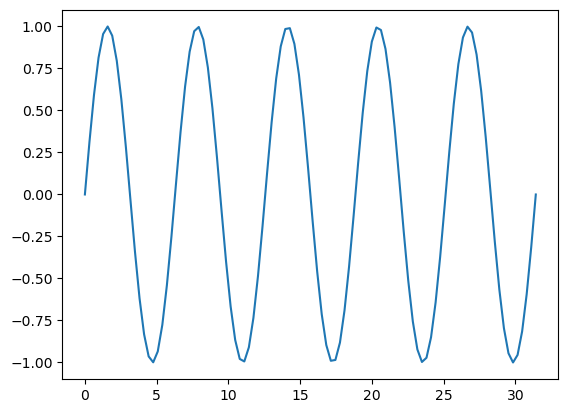

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15adda500>

In [7]:
using LinearAlgebra

# create a sequence of integers from 1 to 100
x = LinRange(0, 10π, 100) 

# create a sequence that approximates a sine wave
y = sin.(x)

# plot the sine wave
plot(x, y)


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


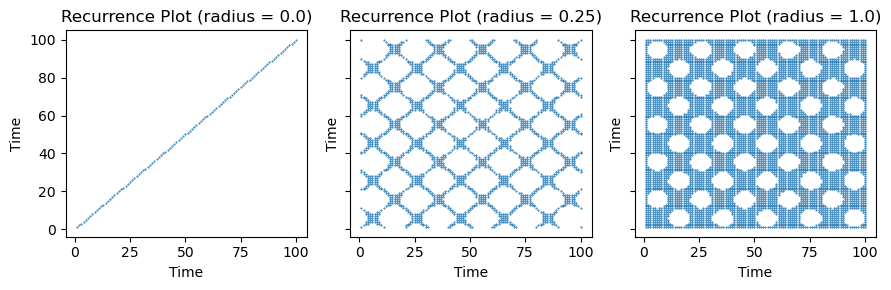

In [8]:
using PyPlot
using DynamicalSystems

# create a sequence of radii to iterate over
radii = [0, .25, 1]

# create a new figure with subplots of equal size
fig, axs = subplots(1, 3, figsize=(9, 3), sharey=true)

# iterate over the radii and create a new plot for each one
for (i, radius) in enumerate(radii)
    # create a recurrence plot with the current radius
    RP = RecurrenceMatrix(y, radius)
    xs, ys = coordinates(RP)
    
    # create a square image of the recurrence plot
    #axs[i].imshow(RP, cmap="gray", aspect="equal")
    
    axs[i].scatter(xs, ys, marker=".", s = 1)
    
    # set the plot title and axis labels
    axs[i].set_title("Recurrence Plot (radius = $radius)")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Time")
end

# adjust the layout of the subplots and display the figure
tight_layout()
show()

As illustrated in the plots above, the recurrence plot with a radius of 0 appears notably sparse. It primarily displays a single line along the diagonal—termed the "line of incidence." This results from every point being recurrent with itself, thus representing the original signal without any repeating patterns. For auto-recurrence, this line of incidence also serves as the line of identity, rendering the plot symmetrical around it. As the radius parameter is increased, the density of recurrent points grows, denoting instances where the signal replicates within a defined tolerance (radius). But what qualifies as "too dense"? While it varies based on the data and the specific questions at hand, a general rule of thumb is for recurrent points to comprise about 5-10% of the recurrence plot. Though this serves as a useful benchmark, remember it's a heuristic. To truly ascertain the optimal radius, experimentation with diverse values to observe resulting variations is key.

Regarding the subsequent musical example, envision the line of incidence as the song's lyrics progressing from the start (bottom left) to the end (top right), devoid of repeating patterns. To visualize the repetition within the lyrics, the radius parameter needs to be increased. However, over-increasing could lead to overfitting, potentially obscuring broader insights. In this instance, maintaining a radius of .01 ensures that repeating patterns for each unique word are captured. Note that given our words are assigned integer values, any radius less than 1 will do.

### Looking at the lyrics data

Here is the resulting recurrence plot for the song "Desperado" by Rihanna. This song has a clear repetitive structure, starting with the chorus introducing the "Desperado", which then repeats three more times between the two verses and two pre-choruses. The pre-chorus sections stay exactly the same each time: "Gotta get up out of here and You ain't leaving me behind I know you won't, 'cause we share common interests", and the two verses open in a similar way, both starting with "Desperado sitting in an old Monte Carlo." Phrases like "I don't wanna be alone" are repeated multiple times, in the choruses and bridge. The repetition of the chorus lyrics, identical pre-choruses, similar verse openings, and phrases like "I don't wanna be alone" create a predictable structure that emphasizes the song's themes.

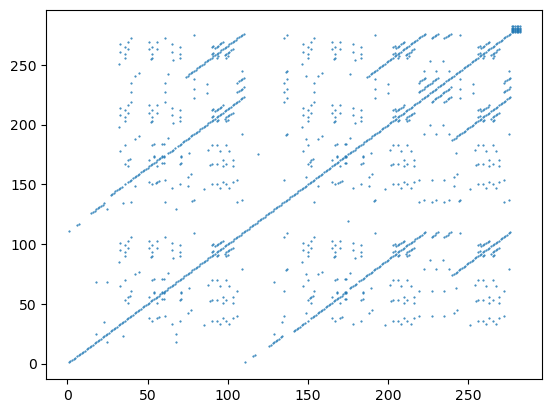

In [9]:
lyrics_series = track_info["Desperado"]["word_series"];

RP = RecurrenceMatrix(lyrics_series, .01);
#using Plots;

# recurrence plot
xs, ys = coordinates(RP);
rec_plot = PyPlot.scatter(xs, ys, s = 1, marker=".");

Looking the plot above you'll notice that prominent diagonal lines appear, indicating that the lyrics of the song repeat themselves. The most prominent (circled in red) captures the sequence of lyrics starting in the second verse (about 1:00) that largely mirror the opening sequence. The small gaps in this line are moments when the lyrics diverge. 

Let's take a look at Hey Jude by the The Beatles. Those familiar with this song will recognize the repetitive structure of the chorus, which repeats the phrase "Hey Jude" multiple times. The verses also have a similar structure, with the first verse opening with "Hey Jude, don't make it bad" and the second verse opening with "Hey Jude, don't be afraid." The bridge is also repetitive, with the phrase "The minute you let her under your skin" repeated multiple times. The chorus is repeated multiple times, and the song ends with a long sequence of "na na na na na na na na" that is repeated over and over.

Here's the plot.

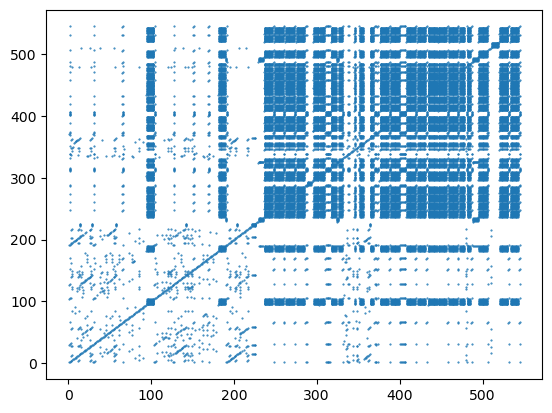

In [10]:
using DynamicalSystems

lyrics_series = track_info["Hey Jude"]["word_series"];

radius = .01;

RP = RecurrenceMatrix(lyrics_series, radius);
#using Plots;

# recurrence plot
xs, ys = coordinates(RP);
rec_plot = PyPlot.scatter(xs, ys, s = 1, marker=".");


We can clearly see the structure of the sequences of repetition. That grid-looking thing in the upper right... there are you na na na na na na na's.

Finally, let's take a look at "5 AM in Toronto" by Drake. This is a rap song notable for its continuous flow and absence of a traditional chorus.

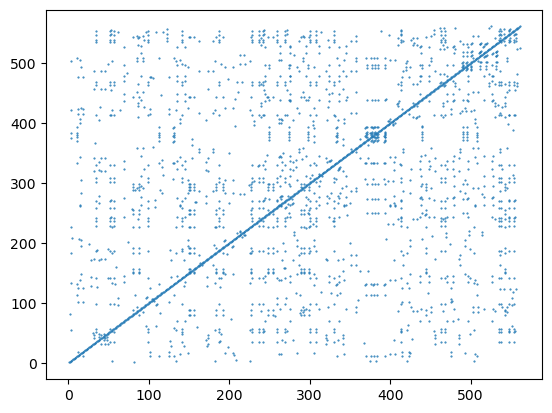

0.006251591545709193

In [11]:
using DynamicalSystems

lyrics_series = track_info["5 AM in Toronto"]["word_series"];

radius = .01;

RP = RecurrenceMatrix(lyrics_series, radius);

#using Plots;
# recurrence plot
xs, ys = coordinates(RP);
rec_plot = PyPlot.scatter(xs, ys, s = 1, marker=".");

rqa_metrics[:RR]

Let's take a look at what we get when we get various aRQA measures from each of these plots.

In [40]:
playlist = ["Desperado", "Hey Jude", "5 AM in Toronto"]

playlist_rqa = DataFrame(title=[], RR=[], DET=[], ENTR=[])

for song in playlist
    lyrics = track_info[song]["word_series"]
    RP = RecurrenceMatrix(lyrics, .01)
    rqa_metrics = rqa(RP; lmin = 2, thieller = 0)
    new_row = DataFrame(title = song, RR = rqa_metrics[:RR], DET = rqa_metrics[:DET], ENTR = rqa_metrics[:ENTR])
    append!(playlist_rqa, new_row)
end

playlist_rqa



Row,title,RR,DET,ENTR
,Any,Any,Any,Any
1,Desperado,0.0147901,0.579848,1.50591
2,Hey Jude,0.147133,0.923981,2.09313
3,5 AM in Toronto,0.00625159,0.127064,0.521438


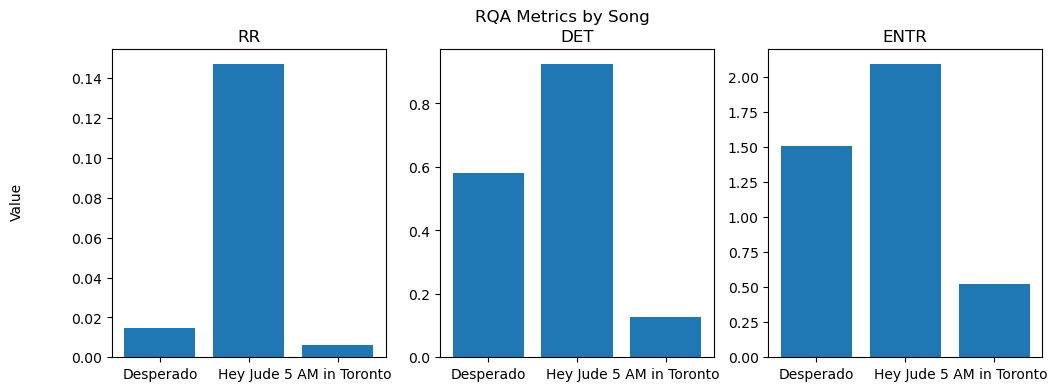

In [42]:
# assuming your DataFrame is called "means_table"
# create a figure with three subplots
fig, axs = subplots(1, 3, figsize=(12, 4))

# plot the mean values for RR in the first subplot
axs[1].bar(playlist_rqa.title, playlist_rqa.RR)
axs[1].set_title("RR")

# plot the mean values for DET in the second subplot
axs[2].bar(playlist_rqa.title, playlist_rqa.DET)
axs[2].set_title("DET")

# plot the mean values for ENTR in the third subplot
axs[3].bar(playlist_rqa.title, playlist_rqa.ENTR)
axs[3].set_title("ENTR")



# set the plot title and axis labels
fig.suptitle("RQA Metrics by Song")
fig.text(0.04, 0.5, "Value", va="center", rotation="vertical")

# display the plot
show()

Looking at the resulting measures, it's pretty apparent that aRQA provides very different measures for RR, DET, and ENTR for each song. Let's unpack this a bit:

- As we might expect, Hey Jude has by far the highest recurrence rate (RR), suggesting that it has the most repeating lyrics. This is consistent with our observations of the song's structure and most likely inflated by the long sequence of "na na na na na na na na" at the end of the song. 5 AM in Toronto has the least, again consitent with what we know from the Recurrence Plot and the structure of repeating lyrics (or lack thereof) in the song.
- Turning our attention to DET, we see again the Hey Jude has the highest score. Whereas RR simply asks if a given word repeats, DET captures the percentage of repeating words that form repeating sequences. Think of it as saying "okay, I've found a repeating word, now is it part of a sequence" For example, in this simple sentence "Easy come, easy go" the word "easy" repeats twice, but in either case it's followed by a different work. Contrast this to "The harder they come, the harder they fall" where "the" not only repeats twice, and in both cases it's followed by the words "harder" and "they" forming a three word sequence. This three word sequence would be visualized by a diagonal line on the Recurrence plot and would be captured by DET. This is why Hey Jude has a high DET score, because it has many repeating sequences. 5 AM in Toronto has the lowest DET score, again consistent with the lack of repeating sequences in the song.
- Finally, let's consider entropy (ENTR). ENTR captures the complexity of the repeating sequences. For example, a song that repeats the same three words over and over again (I'm looking at you Daft Punk!) would have a low ENTR score, because it's not very complex. At the same time it would very likely have a high RR and DET. On the other hand, a song that repeats many different sequences would have a high ENTR score. 

Given this, lets add a few more songs to our analysis and see what we get. I'm going to add "The Boxer" by Simon and Garfunkel, "In the Aeroplane Over the Sea" by Neutral Milk Hotel and "Around the World" by Daft Punk. If you are familiar with these songs, what might you predict about their structure. If you're not, go have a listen (and try not to judge my musical tastes) and come back.

In [43]:
playlist = ["Desperado", "Hey Jude", "5 AM in Toronto", "The Boxer", "In the Aeroplane Over the Sea", "Around the World"]

playlist_rqa = DataFrame(title=[], RR=[], DET=[], ENTR=[])

for song in playlist
    lyrics = track_info[song]["word_series"]
    RP = RecurrenceMatrix(lyrics, .01)
    rqa_metrics = rqa(RP; lmin = 2, thieller = 0)
    new_row = DataFrame(title = song, RR = rqa_metrics[:RR], DET = rqa_metrics[:DET], ENTR = rqa_metrics[:ENTR])
    append!(playlist_rqa, new_row)
end

playlist_rqa

Row,title,RR,DET,ENTR
,Any,Any,Any,Any
1,Desperado,0.0147901,0.579848,1.50591
2,Hey Jude,0.147133,0.923981,2.09313
3,5 AM in Toronto,0.00625159,0.127064,0.521438
4,The Boxer,0.11743,0.863147,1.35108
5,In the Aeroplane Over the Sea,0.00793577,0.224796,0.977925
6,Around the World,0.274827,0.997691,0.129167


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


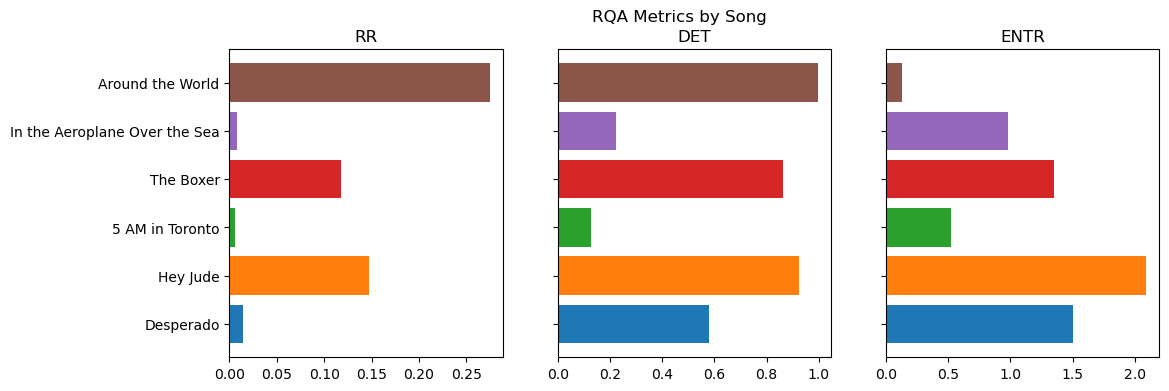

In [44]:
using PyPlot
using DataFrames

# assuming your DataFrame is called "playlist_rqa"
# create a figure with three subplots
fig, axs = subplots(1, 3, figsize=(12, 4))

# create a list of colors for each song
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]

# plot the mean values for RR in the first subplot
axs[1].barh(playlist_rqa.title, playlist_rqa.RR, color=colors)
axs[1].set_title("RR")

# plot the mean values for DET in the second subplot
axs[2].barh(playlist_rqa.title, playlist_rqa.DET, color=colors)
axs[2].set_title("DET")
axs[2].set_yticklabels([])

# plot the mean values for ENTR in the third subplot
axs[3].barh(playlist_rqa.title, playlist_rqa.ENTR, color=colors)
axs[3].set_title("ENTR")
axs[3].set_yticklabels([])

# set the plot title and axis labels
fig.suptitle("RQA Metrics by Song")
#fig.text(0.04, 0.5, "Value", va="center", rotation="vertical")

# display the plot
show()

## Conclusions

In this example, we've used song lyrics as a familiar gateway to build insights and intuitions about aRQA. The rhythmic patterns and recurring themes in music have allowed us to get a feel for the capabilities of recurrence analysis in an accessible manner. That said, you might easily build on this analysis, perhaps using aRQA measures as a basis for clustering songs into genres or artists for music recommendation. For aspiring songwriters or purveyors of music, understanding recurrent patterns in popular songs might provide insights into what makes a song catchy. Combined with other tools, aRQA could offer a deeper dive into the sentiment progression of a song, revealing how emotions ebb and flow throughout; and aRQA's analytical cousin, cross-recurrence quantification analysis (see you at letter C, maybe) has been used to identify cover songs and plagiarism.

 Of course, the potential applications of this approach extend far beyond just lyrics. One can easily envision adapting this framework to a number of other use cases, from analyzing textual patterns in literature and historical documents to discerning behavioral trends in social networks, to predicting breakdowns in machines—including biological ones. The possibilities are endless.

In [15]:
using DynamicalSystems

all_track_info = DataFrame()
i = 0

# loop through each row of the DataFrame
for row in eachrow(song_data)
    i += 1
    println(i)
    # get the artist name, original lyrics, and cleaned lyrics
    artist = row.artist
    song = row.title
    key = "$artist - $song"
    lyrics = row.lyrics
    genre = row.tag
    cleaned_lyrics = lyrics_cleaner(lyrics)
    
    # convert the cleaned lyrics to word numbers using the word_dict
    words = split(cleaned_lyrics)
    
    
    # create word_dictionary:
    unique_words = unique(words)
    word_dict = Dict(unique_words .=> 1:length(unique_words))
    #word_num_list = Any[]

    word_num_list = [word_dict[word] for word in words]
    
    RP = RecurrenceMatrix(lyrics_series, radius);
    
    rqa_metrics = rqa(RP; lmin = 2, thieller = 0) 
    
    RR = rqa_metrics[:RR]
    DET = rqa_metrics[:DET]
    ENTR = rqa_metrics[:ENTR]
    
    
    
    # add the artist info to the Dict
    all_track_info[key] = Dict("artist" => artist,
                           "title" => song,
                            "lyrics" => lyrics,
                            "genre" => genre,
                            "cleaned_lyrics" => cleaned_lyrics,
                            "word_series" => word_num_list,
                            "RR" => RR,
                            "DET" => DET,
                            "ENTR" => ENTR)
end

1


LoadError: ArgumentError: syntax df[column] is not supported use df[!, column] instead

In [ ]:
using DataFrames
using StatsBase
using DynamicalSystems

sample_rows = sample(1:nrow(song_data), floor(Int, 0.001 * nrow(song_data)), replace=false)

sampled_df = song_data[sample_rows, :]

# create an empty DataFrame with the desired column names
all_track_info = DataFrame(artist=[], title=[], lyrics=[], genre=[], cleaned_lyrics=[], RR=[], DET=[], ENTR=[])
i = 0

# loop through each row of the DataFrame
for row in eachrow(sampled_df)
    #i += 1
    #println(i)
    
    # get the artist name, original lyrics, and cleaned lyrics
    artist = row.artist
    song = row.title
    key = "$artist - $song"
    lyrics = row.lyrics
    genre = row.tag
    cleaned_lyrics = lyrics_cleaner(lyrics)
    
    # convert the cleaned lyrics to word numbers using the word_dict
    words = split(cleaned_lyrics)
    unique_words = unique(words)
    word_dict = Dict(unique_words .=> 1:length(unique_words))
    word_num_list = [word_dict[word] for word in words]
    
    RP = RecurrenceMatrix(word_num_list, radius);
    
    rqa_metrics = rqa(RP; lmin = 2, thieller = 0) 
    
    RR = rqa_metrics[:RR]
    DET = rqa_metrics[:DET]
    ENTR = rqa_metrics[:ENTR]
    RTE = rqa_metrics[:RTE]
    
    # create a new row for the DataFrame
    new_row = DataFrame(artist=artist, title=song, lyrics=lyrics, genre=genre, cleaned_lyrics=cleaned_lyrics, RR=RR, DET=DET, ENTR=ENTR)
    
    # append the new row to the existing DataFrame
    append!(all_track_info, new_row)
end


delete!(all_track_info, isnan.(all_track_info.RR))
delete!(all_track_info, isnan.(all_track_info.DET))
delete!(all_track_info, isnan.(all_track_info.ENTR))

 


Row,genre,RR_mean,DET_mean,ENTR_mean
,Any,Float64,Float64,Float64
1,rock,0.023802,0.467887,1.1012
2,rap,0.0226218,0.338412,0.911964
3,pop,0.0255442,0.481651,1.1201
4,misc,0.0130123,0.192187,0.514266
5,rb,0.0230695,0.476983,1.16924
6,country,0.0257395,0.40673,1.03142


In [ ]:
group_genre = groupby(all_track_info,:genre) 

means_table = combine(group_genre, :RR => mean, :DET => mean, :ENTR => mean)

means_table = @chain means_table begin
    @filter(genre != "misc")
end



Row,genre,RR_mean,DET_mean,ENTR_mean
,Any,Float64,Float64,Float64
1,rock,0.023802,0.467887,1.1012
2,rap,0.0226218,0.338412,0.911964
3,pop,0.0255442,0.481651,1.1201
4,rb,0.0230695,0.476983,1.16924
5,country,0.0257395,0.40673,1.03142


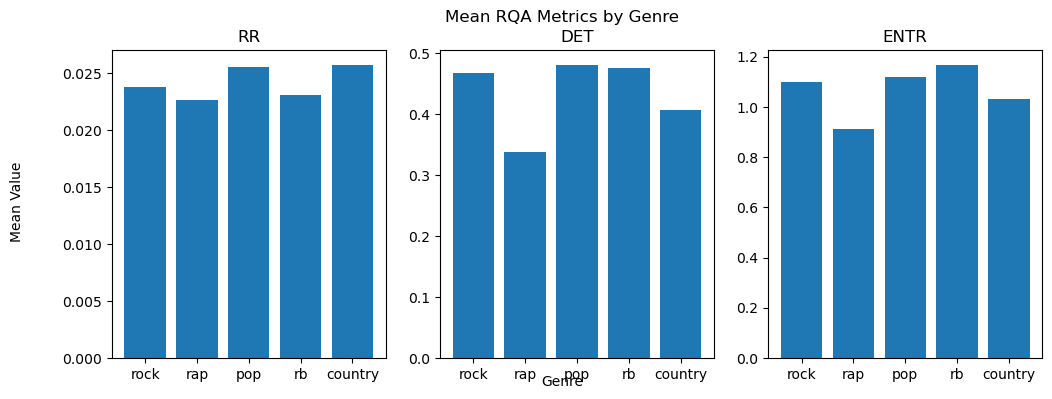

In [ ]:
using PyPlot
using DataFrames

# assuming your DataFrame is called "means_table"
# create a figure with three subplots
fig, axs = subplots(1, 3, figsize=(12, 4))

# plot the mean values for RR in the first subplot
axs[1].bar(means_table.genre, means_table.RR_mean)
axs[1].set_title("RR")

# plot the mean values for DET in the second subplot
axs[2].bar(means_table.genre, means_table.DET_mean)
axs[2].set_title("DET")

# plot the mean values for ENTR in the third subplot
axs[3].bar(means_table.genre, means_table.ENTR_mean)
axs[3].set_title("ENTR")

# set the plot title and axis labels
fig.suptitle("Mean RQA Metrics by Genre")
fig.text(0.5, 0.04, "Genre", ha="center")
fig.text(0.04, 0.5, "Mean Value", va="center", rotation="vertical")

# display the plot
show()